In [122]:
#for tablular data managment 
import pandas as pd 
#for scientific plotting 
import seaborn as sns 
import matplotlib.pyplot as plt
#pythons premiere numerical computing library 
import numpy as np
from sklearn.model_selection import GridSearchCV
plt.style.use('ggplot')
%matplotlib inline
#Read in csv from Burlington Open data
df = pd.read_csv("https://opendata.arcgis.com/datasets/276ccff527454496ac940b60a2641dda_0.csv")
#Split the 'PropertyCenterPoint' column into 'Latitude' and 'Longitude' in a seperate dataframe
df2 = df['PropertyCenterPoint'].str.strip('()').str.split(', ', expand=True).rename(columns={0:'Longitude', 1:'Latitude'})
df3 = df['Baths'].str.split('/', expand=True).rename(columns={0:'Full_Baths', 1:'Half_Baths'})
# create a dataframe with the new variables
df = pd.concat([df, df2, df3],axis=1)
#remove property center point because it is no longer needed
df.drop('PropertyCenterPoint', 1, inplace = True)
# do type conversions so that columns have the proper type
df['Half_Baths'] = pd.to_numeric(df['Half_Baths'])
df['Full_Baths'] = pd.to_numeric(df['Full_Baths'])
df['Latitude'] = pd.to_numeric(df['Latitude'])
df['Longitude'] = pd.to_numeric(df['Longitude'])
# print the number of rows and columns that the dataframe has
print(df.shape)

(10832, 42)


In [123]:
from sklearn.model_selection import cross_val_score
df['SaleDate'] = pd.to_datetime(df['SaleDate'])
modeldf = df.drop(['AccountNumber', 'ParcelID', 'SpanNumber', 'StreetNumber',
       'AlternateNumber', 'Unit', 'CuO1LastName',
       'CuO1FirstName', 'CuO2LastName', 'CuO2FirstName', 'CuO3LastName',
       'CuO3FirstName','LegalReference', 'GrantorLastName', 'FID', 'Baths'], axis = 1)

modeldf['Latitude'] = pd.to_numeric(modeldf['Latitude'])
modeldf['Longitude'] = pd.to_numeric(modeldf['Longitude'])
modeldf['Sale_Year'] = modeldf['SaleDate'].apply(lambda row: row.year)
modeldf.drop('SaleDate', axis=1, inplace= True)
modeldf = modeldf[(modeldf['LandUse'] == "Single Family") | (modeldf['LandUse'] == "Residential Condo")]
modeldf = pd.get_dummies(modeldf)
#pulled cityhall gps coords from this https://www.maps.ie/coordinates.html
from geopy.distance import great_circle
distances = []
preprocessed = modeldf.copy()
modeldf = modeldf[modeldf['SalePrice']> 0]
modeldf.dropna(inplace = True)
for i, j in zip(modeldf['Latitude'], modeldf['Longitude']):
    val = (i, j)
    Cityhall = (44.47647568031712, -73.21353835752235)
    dist = great_circle(val,Cityhall).miles
    distances.append(dist)
    


#modeldf['Distances'] = distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler
Xframe = modeldf.drop(['SalePrice'], axis=1)
data_names = Xframe.columns
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(Xframe)
y=modeldf['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=123)
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor().fit(X_train, y_train)

clf.score(X_test, y_test)

cv_scores = cross_val_score(clf, X_train,y_train,n_jobs=-1, cv = 10)
gradient_score = clf.predict(X_test)
for score in cv_scores:
    print(score)
print("mean score:", np.mean(cv_scores))

/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8749373916274858
0.8798583824853712
0.8945549115053592
0.8276437527085095
0.84536951928016
0.8682051614218858
0.6392791037982882
0.8317705232978257
0.8097423045510663
0.6113032481480531
mean score: 0.8082664298824005


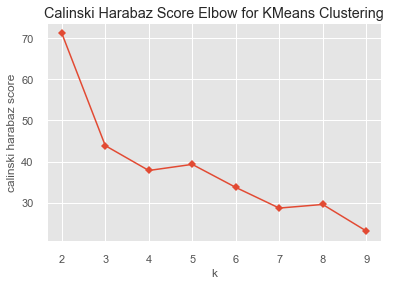

In [124]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,10), metric='calinski_harabaz', timings=False
)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [125]:
modeldf['cluster'] = KMeans(n_clusters=4).fit_predict(X)

In [126]:
standard_scaler = StandardScaler()
modeldf[['TotalGrossArea', 'SalePrice', 'CurrentValue', 'CurrentLandValue', 'NumofRooms', 'FinishedArea', 'NumofBedrooms', 'YearBlt']] = standard_scaler.fit_transform(modeldf[['TotalGrossArea', 'SalePrice', 'CurrentValue', 'CurrentLandValue', 'NumofRooms', 'FinishedArea', 'NumofBedrooms', 'YearBlt']])

/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


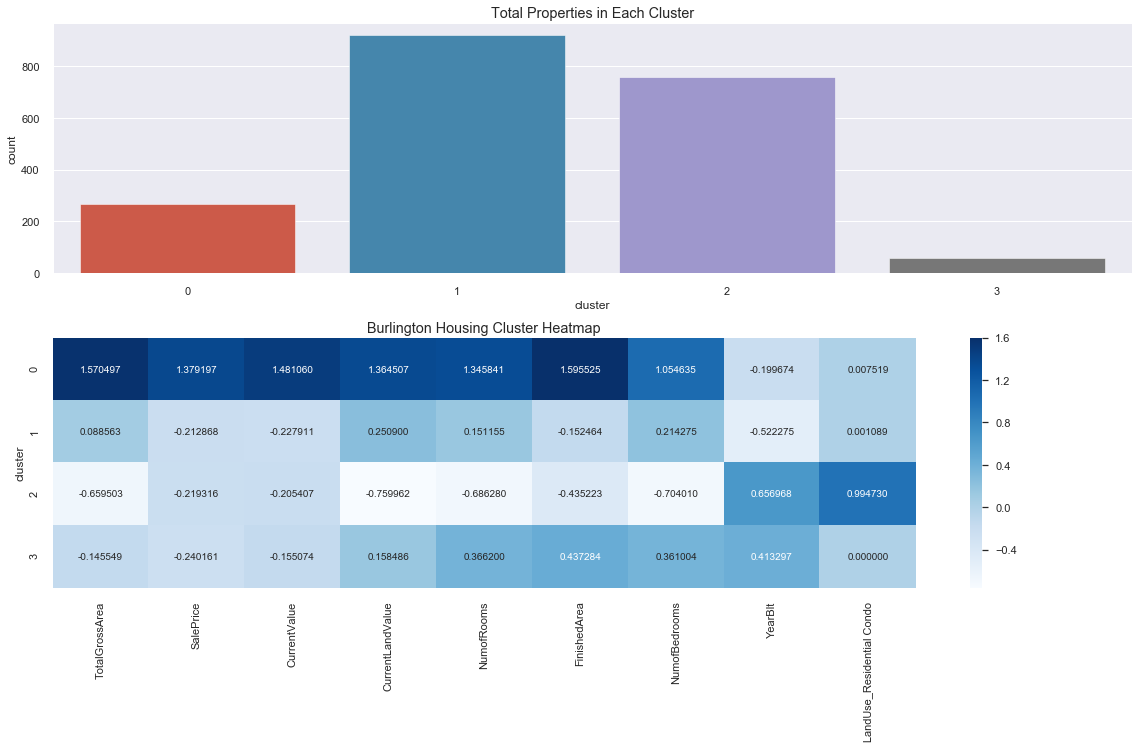

In [138]:
import seaborn as sns 
sns.set_style("darkgrid")
fig, ax = plt.subplots(2,1, figsize = (16, 10.5))
ax = ax.ravel()
sns.heatmap(modeldf.groupby('cluster').mean()[['TotalGrossArea', 'SalePrice', 'CurrentValue', 'CurrentLandValue', 'NumofRooms', 'FinishedArea', 'NumofBedrooms', 'YearBlt', 'LandUse_Residential Condo']], annot = True, fmt="f",
           cmap = 'Blues', ax = ax[1])
ax[1].set_title("Burlington Housing Cluster Heatmap")

sns.countplot(modeldf['cluster'], ax = ax[0])
ax[0].set_title('Total Properties in Each Cluster')
plt.tight_layout()
plt.show()



In [129]:
m = folium.Map(location=[44.475883,  -73.212074])
modeldf = modeldf.sample(n=2000)
for i, j, k in zip(modeldf['Latitude'], modeldf['Longitude'], modeldf['cluster']):
    import folium
    
    if k == 0:
        folium.CircleMarker([i, j], color = 'orange').add_to(m)
        
    elif k == 1:
        folium.CircleMarker([i, j], color = 'blue').add_to(m)
    elif k == 2:
        folium.CircleMarker([i, j], color = 'yellow').add_to(m)
    else:
        folium.CircleMarker([i, j], color = 'green').add_to(m)
m

In [21]:
preprocessed.drop('SalePrice', 1, inplace = True)
preprocessed['Sale_Year'] = 2015
preprocessed.dropna(inplace=True)
distances = []
for i, j in zip(preprocessed['Latitude'], preprocessed['Longitude']):
    val = (i, j)
    Cityhall = (44.47647568031712, -73.21353835752235)
    dist = great_circle(val,Cityhall).miles
    distances.append(dist)
preprocessed['distance'] = distances

In [22]:
X = preprocessed
X = pd.get_dummies(X)

X = standard_scaler.transform(X)
preprocessed['pred'] = clf.predict(X)
preprocessed['diff'] = preprocessed['pred'] - preprocessed['CurrentValue']
under = []
for i in preprocessed['diff']: 
    if i > 0:
        under.append('Over')
    if i <= 0:
        under.append('Under')
preprocessed['under'] = under

/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [15]:
preprocessed = preprocessed.sample(n= 3451)
top = np.percentile(preprocessed['pred'],95)
bottom = np.percentile(preprocessed['pred'],5)
toMap = preprocessed[preprocessed.pred >= top]
toMap2 = preprocessed[preprocessed['pred'] <= bottom]
import folium
m = folium.Map(location=[44.475883,  -73.212074])
x = 0
y = 0
for i, j in zip(toMap['Latitude'], toMap['Longitude']):
    folium.CircleMarker([i, j], color = 'red').add_to(m)
    x += 1
for i, j in zip(toMap2['Latitude'], toMap2['Longitude']):
    folium.CircleMarker([i, j], color = 'blue').add_to(m)
    y += 1
m